In [1]:
import numpy as np
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import re

import cvxopt as opt
from cvxopt import blas, solvers

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
tokenA = open("../tokenA.txt", "r").read()

Aplicar herramientas de optimización sobre un portafolio de inversión.

El proyecto desarrollado en el bootcamp de "Data Analytics", considera la aplicación de herramientas de análisis cuantitativo y cualitativo sobre una tarea de optimización de portafolios de inversión.

Secciones generales:

* Selección manual de instrumentos financieros (US's stocks) y cálculo de portafolios óptimos de inversión.
* Recomendación de instrumentos financieros.
* Diseño de una estrategía de "ranking" con base en factores y cálculo de portafolios óptimos.
* Implementación de sistema de trading, sujeto a restricciones de riesgo.

Como parte de este proyecto hicimos uso de la plataforma de Quantopian para tener acceso a datos del mercado, datasets con información fundamental sobre cada instrumento además de algunas otras herramientas que se usaron como parte del proceso de evaluación de portafolios de inversión y el diseño de un sistema de trading. 

## Datasets.

Es necesario establecer algunos parametros para generar un portafolio.

Para el proceso de construcción se necestian parametros que perfilen el riesgo que asumira el inversionista.

Caracteristicas como la frecuencia de los datos que utilizara.
* ['1min' , '5min', '15min', '30min', '60min','daily','weekly','monthly']

El universo de stocks sobre el cual trabajara (alrededor de 8000 stocks posibles).
* ['AAPL','MSFT','TSLA','AMZN']


Construimos una estructura de pandas con los datos de cada stock.

In [4]:
# Seleccionamos los nombres de los stocks a utiliar
ticker_stocks = ['AAPL','MSFT','TSLA','AMZN']

# Frecuencia de los datos.
freqs_support = ['1min' , '5min', '15min', '30min', '60min','daily','weekly','monthly']
freq_selected = 'daily'

# En que periodo se trabajara el análisis.
period_work = 100

In [5]:
# Peticiones a la API.
def request_dataA(stock,freq,period):
    # Hacemos distinción en datos diarios, semanales y mensuales.
    large_timeframe = ['daily','weekly','monthly']
    if freq.lower() in large_timeframe:
        petition = 'https://www.alphavantage.co/query?function=TIME_SERIES_{}&symbol={}&apikey={}'.format(freq.upper(),stock,tokenA)
    else:
        petition = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={}&interval={}&apikey={}'.format(stock,freq.lower(),tokenA)
    data = requests.get(petition).json()
    stock = pd.DataFrame.from_dict(data['Time Series ({})'.format(freq.capitalize())]).T
    return stock

In [6]:
# Obtenemos los datos de todas las stocks seleccionadas.
data = {}
for stock in ticker_stocks:
    data_stock = request_dataA(stock,freq_selected,period_work)
    # Creamos un diccionario cuya 'key' sea el nombre del stock y el value un dataframe
    # que contenga su información más relevante en precio.
    data[stock] = data_stock
    # Constuimos un Multiindex DataFrame
stocks = pd.concat(data)

In [7]:
stocks.head(3)

1. open   2. high    3. low  4. close 5. volume
AAPL 2019-09-10  213.8600  216.7800  211.7100  216.7000  28279867
     2019-09-09  214.8400  216.4400  211.0700  214.1700  27295300
     2019-09-06  214.0500  214.4200  212.5100  213.2600  19362300

Dentro del ambito de inversión en stocks, nos interesa evaluar los portafolios con base en los returns, esto es la diferencia porcentual entre el valor de un stock en el tiempo "t" y su valor en "t-1".

In [8]:
returns_stocks = pd.DataFrame(columns=ticker_stocks)
for stock in ticker_stocks:
    returns_stocks[stock] = stocks.loc[stock]['4. close'].sort_index().apply(float).pct_change()

In [9]:
returns_stocks.head(3)

,AAPL,MSFT,TSLA,AMZN
2019-04-18,NaN,NaN,NaN,NaN
2019-04-22,0.003287,0.003161,-0.038462,0.013762
2019-04-23,0.014423,0.013575,0.004377,0.019319


In [10]:
# Eliminamos la primera fila de los retornos
returns_stocks.drop(returns_stocks.index[0],inplace=True)

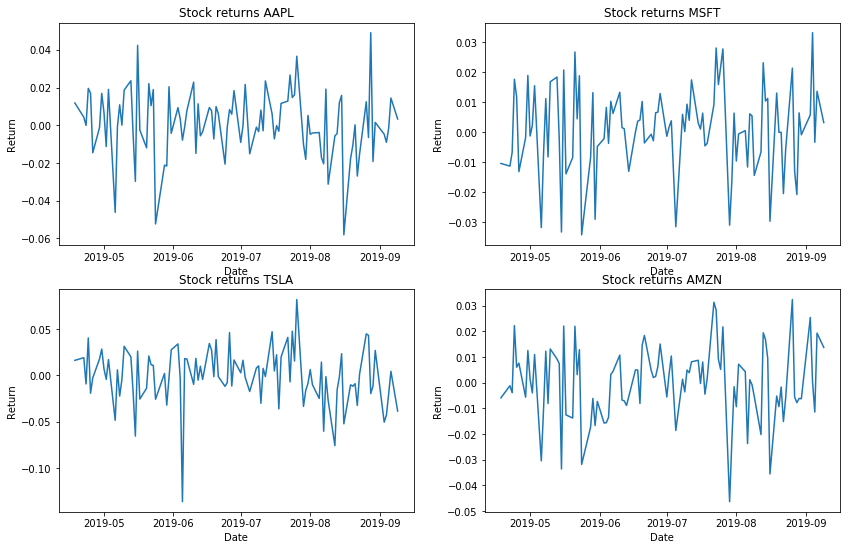

In [11]:
plt.subplots(2,2,figsize=[14,9])

for sub in range(4):
    plt.subplot(2,2,sub+1)
    plt.title('Stock returns {}'.format(ticker_stocks[sub]))
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.plot(pd.to_datetime(stocks.loc[ticker_stocks[sub]].index[1:]),returns_stocks[ticker_stocks[sub]])

## Segunda etapa.

Optimización de portafolios aleatorios con datos de la primera etapa.

In [2]:
import numpy as np
import pandas as pd
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import re

import cvxopt as opt
from cvxopt import blas, solvers

In [3]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [4]:
tokenA = open("../tokenA.txt", "r").read()

Aplicar herramientas de optimización sobre un portafolio de inversión.

El proyecto desarrollado en el bootcamp de "Data Analytics", considera la aplicación de herramientas de análisis cuantitativo y cualitativo sobre una tarea de optimización de portafolios de inversión.

Secciones generales:

* Selección manual de instrumentos financieros (US's stocks) y cálculo de portafolios óptimos de inversión.
* Recomendación de instrumentos financieros.
* Diseño de una estrategía de "ranking" con base en factores y cálculo de portafolios óptimos.
* Implementación de sistema de trading, sujeto a restricciones de riesgo.

Como parte de este proyecto hicimos uso de la plataforma de Quantopian para tener acceso a datos del mercado, datasets con información fundamental sobre cada instrumento además de algunas otras herramientas que se usaron como parte del proceso de evaluación de portafolios de inversión y el diseño de un sistema de trading. 

## Datasets.

Es necesario establecer algunos parametros para generar un portafolio.

Para el proceso de construcción se necestian parametros que perfilen el riesgo que asumira el inversionista.

Caracteristicas como la frecuencia de los datos que utilizara.
* ['1min' , '5min', '15min', '30min', '60min','daily','weekly','monthly']

El universo de stocks sobre el cual trabajara (alrededor de 8000 stocks posibles).
* ['AAPL','MSFT','TSLA','AMZN']


Construimos una estructura de pandas con los datos de cada stock.

In [5]:
# Seleccionamos los nombres de los stocks a utiliar
ticker_stocks = ['AAPL','MSFT','TSLA','AMZN']

# Frecuencia de los datos.
freqs_support = ['1min' , '5min', '15min', '30min', '60min','daily','weekly','monthly']
freq_selected = 'daily'

# En que periodo se trabajara el análisis.
period_work = 100

In [10]:
# Peticiones a la API.
def request_dataA(stock,freq,period):
    # Hacemos distinción en datos diarios, semanales y mensuales.
    large_timeframe = ['daily','weekly','monthly']
    if freq.lower() in large_timeframe:
        petition = 'https://www.alphavantage.co/query?function=TIME_SERIES_{}&symbol={}&apikey={}'.format(freq.upper(),stock,tokenA)
    else:
        petition = 'https://www.alphavantage.co/query?function=TIME_SERIES_INTRADAY&symbol={}&interval={}&apikey={}'.format(stock,freq.lower(),tokenA)
    data = requests.get(petition).json()
    stock = pd.DataFrame.from_dict(data['Time Series ({})'.format(freq.capitalize())]).T
    return stock

In [11]:
# Obtenemos los datos de todas las stocks seleccionadas.
data = {}
for stock in ticker_stocks:
    data_stock = request_dataA(stock,freq_selected,period_work)
    # Creamos un diccionario cuya 'key' sea el nombre del stock y el value un dataframe
    # que contenga su información más relevante en precio.
    data[stock] = data_stock
    # Constuimos un Multiindex DataFrame
stocks = pd.concat(data)

In [12]:
stocks.head(3)

1. open   2. high    3. low  4. close 5. volume
AAPL 2019-09-10  213.8600  216.7800  211.7100  216.7000  28279867
     2019-09-09  214.8400  216.4400  211.0700  214.1700  27295300
     2019-09-06  214.0500  214.4200  212.5100  213.2600  19362300

Dentro del ambito de inversión en stocks, nos interesa evaluar los portafolios con base en los returns, esto es la diferencia porcentual entre el valor de un stock en el tiempo "t" y su valor en "t-1".

In [13]:
returns_stocks = pd.DataFrame(columns=ticker_stocks)
for stock in ticker_stocks:
    returns_stocks[stock] = stocks.loc[stock]['4. close'].sort_index().apply(float).pct_change()

In [14]:
returns_stocks.head(3)

,AAPL,MSFT,TSLA,AMZN
2019-04-18,NaN,NaN,NaN,NaN
2019-04-22,0.003287,0.003161,-0.038462,0.013762
2019-04-23,0.014423,0.013575,0.004377,0.019319


In [15]:
# Eliminamos la primera fila de los retornos
returns_stocks.drop(returns_stocks.index[0],inplace=True)

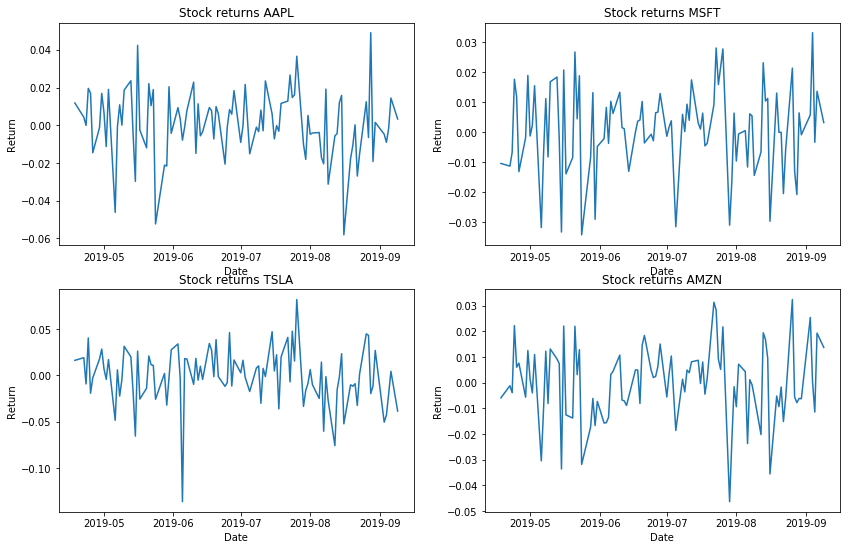

In [16]:
plt.subplots(2,2,figsize=[14,9])

for sub in range(4):
    plt.subplot(2,2,sub+1)
    plt.title('Stock returns {}'.format(ticker_stocks[sub]))
    plt.xlabel('Date')
    plt.ylabel('Return')
    plt.plot(pd.to_datetime(stocks.loc[ticker_stocks[sub]].index[1:]),returns_stocks[ticker_stocks[sub]])

## Segunda etapa.

Obtención de portafolios optimos en un grupo de portafolios aleatorios.

In [17]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

In [18]:
def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
        
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 0.5:
        return random_portfolio(returns)
    return mu, sigma

In [19]:
return_vec = np.array(returns_stocks.T)

In [20]:
return_vec.shape

(4, 99)

In [21]:
n_portfolios = 500
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for _ in range(n_portfolios)
])

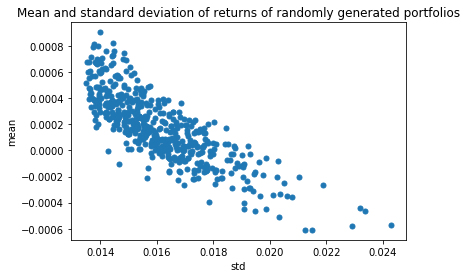

In [22]:
plt.plot(stds, means, 'o', markersize=5)
plt.xlabel('std')
plt.ylabel('mean')
plt.title('Mean and standard deviation of returns of randomly generated portfolios');

In [23]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

weights, returns, risks = optimal_portfolio(return_vec)

     pcost       dcost       gap    pres   dres
 0: -1.6873e-04 -1.0011e+00  1e+00  4e-16  3e+00
 1: -1.7010e-04 -1.1087e-02  1e-02  1e-16  3e-02
 2: -2.8223e-04 -1.1858e-03  9e-04  1e-16  2e-03
 3: -9.9025e-04 -1.3500e-03  4e-04  1e-15  5e-04
 4: -1.0786e-03 -1.0843e-03  6e-06  1e-16  7e-06
 5: -1.0816e-03 -1.0816e-03  6e-08  2e-16  7e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.6726e-04 -1.0011e+00  1e+00  1e-16  3e+00
 1: -1.6864e-04 -1.1086e-02  1e-02  6e-17  3e-02
 2: -2.8094e-04 -1.1851e-03  9e-04  1e-16  2e-03
 3: -9.9058e-04 -1.3492e-03  4e-04  7e-16  5e-04
 4: -1.0775e-03 -1.0831e-03  6e-06  3e-18  7e-06
 5: -1.0803e-03 -1.0804e-03  6e-08  1e-16  7e-08
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -1.6561e-04 -1.0011e+00  1e+00  2e-16  3e+00
 1: -1.6699e-04 -1.1085e-02  1e-02  6e-17  3e-02
 2: -2.7949e-04 -1.1843e-03  9e-04  8e-17  2e-03
 3: -9.9093e-04 -1.3483e-03  4e-04  7e-16  5e-04
 4: -1.0761e-03 -1.0817e

 5:  2.7616e-03  2.7592e-03  2e-06  3e-17  2e-18
 6:  2.7595e-03  2.7594e-03  4e-08  2e-16  1e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.1370e-03 -9.9881e-01  1e+00  4e-16  3e+00
 1:  5.0995e-03 -8.7754e-03  1e-02  1e-16  3e-02
 2:  4.1355e-03  2.0597e-03  2e-03  6e-17  4e-03
 3:  3.3753e-03  2.9075e-03  5e-04  1e-16  2e-18
 4:  3.2518e-03  3.2072e-03  4e-05  1e-16  2e-18
 5:  3.2236e-03  3.2205e-03  3e-06  3e-16  3e-18
 6:  3.2213e-03  3.2211e-03  2e-07  6e-17  2e-18
 7:  3.2211e-03  3.2211e-03  6e-09  5e-19  3e-18
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.7784e-03 -9.9852e-01  1e+00  4e-16  3e+00
 1:  5.7334e-03 -8.4810e-03  1e-02  6e-17  4e-02
 2:  4.6601e-03  2.4913e-03  2e-03  1e-16  5e-03
 3:  3.8884e-03  3.4176e-03  5e-04  3e-17  2e-18
 4:  3.7663e-03  3.7207e-03  5e-05  1e-16  3e-18
 5:  3.7399e-03  3.7367e-03  3e-06  1e-16  2e-18
 6:  3.7384e-03  3.7382e-03  2e-07  1e-16  3e-18
 7:  3.7383e-03  3.7383

     pcost       dcost       gap    pres   dres
 0: -1.8057e-04 -1.0011e+00  1e+00  0e+00  3e+00
 1: -1.8192e-04 -1.1092e-02  1e-02  1e-16  3e-02
 2: -2.9265e-04 -1.1917e-03  9e-04  8e-17  2e-03
 3: -9.8756e-04 -1.3563e-03  4e-04  9e-16  5e-04
 4: -1.0883e-03 -1.0942e-03  6e-06  6e-18  8e-06
 5: -1.0916e-03 -1.0916e-03  6e-08  3e-16  8e-08
Optimal solution found.


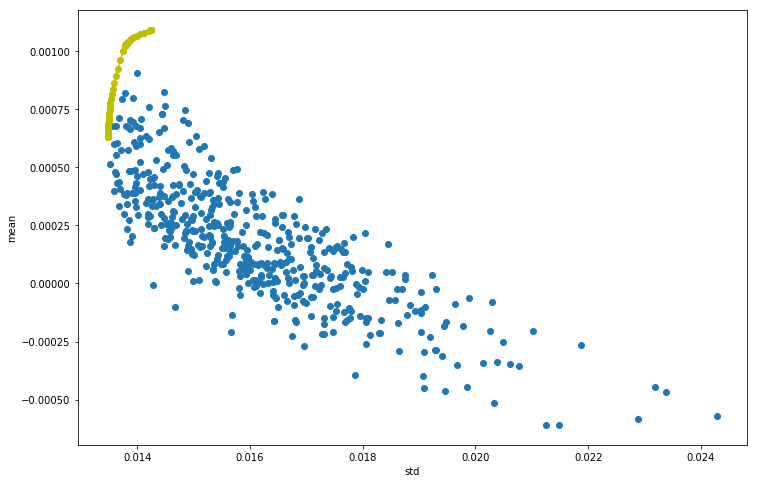

In [24]:
plt.subplots(1,1,figsize=[12,8])
plt.plot(stds, means, 'o')
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o');

In [25]:
weight_stock = pd.DataFrame(columns=['stock','weight'])
weight_stock['weight'] = pd.Series(weights[:,0]*100)
weight_stock['stock'] = ticker_stocks
weight_stock

,stock,weight
0,AAPL,0.000627
1,MSFT,99.997433
2,TSLA,0.000808
3,AMZN,0.001133
